In [12]:
import numpy as np
import random
import gc
import os
import os.path
import re

In [13]:
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
import tensorflow as tf

In [14]:

def file_name(file_dir):
    for root, dirs, files in os.walk(file_dir):
        return files


def data_prepare(file_dir):
    # prepare reads from normal plasma
    normal_seq = []
    normal_methy = []
    normal_chrom = []
    normal_region = []
    files = file_name(file_dir)
    for file in files:
#        if 'CTR' in file:  # keyword for normal plasma samples for training
        if 'normal' in file:  # keyword for normal plasma samples for training    
            input_norm = open(file_dir +'\\'+ file, 'r')
            for item in input_norm:
                item = item.split()
                cpg = 0
                if len(item[2]) == 66:  # check the length
                    for i in range(len(item[2]) - 1):
                        if (item[2][i] == 'C') & (item[2][i + 1] == 'G'):
                            cpg = cpg + 1
                    if cpg > 2: # filter out reads with less than 3 CpG sites
                        normal_chrom.append(item[0])
                        normal_region.append(item[1])
                        normal_seq.append(item[2])
                        normal_methy.append(item[3])
            input_norm.close()

    # prepare reads from cancer tissue
    tumor_seq = []
    tumor_methy = []
    tumor_chrom = []
    tumor_region = []
    files = file_name(file_dir)
    flag = 0
    for file in files:
  #      if 'HOT' in file and 'T-sorted' in file: # keyword for cancer tissue samples for training
        if 'tumor' in file : # keyword for cancer tissue samples for training
            input_tumor = open(file_dir + '\\'+file, 'r')
            for item in input_tumor:
                item = item.split()
                cpg = 0
                if len(item[2]) == 66:
                    for i in range(len(item[2]) - 1):
                        if (item[2][i] == 'C') & (item[2][i + 1] == 'G'):
                            cpg = cpg + 1
                    if cpg > 2: # filter out reads with less than 3 CpG sites
                        tumor_chrom.append(item[0])
                        tumor_region.append(item[1])
                        tumor_seq.append(item[2])
                        tumor_methy.append(item[3])
            input_tumor.close()
        flag = flag + 1
    return normal_seq, normal_methy, normal_chrom, normal_region, tumor_seq, tumor_methy, tumor_chrom, tumor_region


# transform sequence into number for storage (A/T/C/G to 0/1/2/3, methylated C to 4)
def lstm_seq(seq, methy):
    i = 0
    lstmseq = np.zeros((len(seq), 66), dtype='int')
    while i < len(seq):
        tmp = seq[i]
        j = 0
        while j < len(tmp):
            if tmp[j] == 'A':
                lstmseq[i, j] = 0
            elif tmp[j] == 'T':
                lstmseq[i, j] = 1
            elif tmp[j] == 'C':
                lstmseq[i, j] = 2
            else:
                lstmseq[i, j] = 3
            if int(methy[i][j]) == 1:
                lstmseq[i, j] = 4
            j = j + 1
        i = i + 1
    return lstmseq


# transform sequence into one-hot code (0/1/2/3 to one-hot) and add methylation state channel
def conv_onehot(seq):
    module = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 1]])
    onehot = np.zeros((len(seq), 66, 5), dtype='int')
    for i in range(len(seq)):
        tmp = seq[i]
        tmp_onehot = np.zeros((66, 5), dtype='int')
        for j in range(len(tmp)):
            if tmp[j] == 0:
                tmp_onehot[j] = module[0]
            elif tmp[j] == 1:
                tmp_onehot[j] = module[1]
            elif tmp[j] == 2:
                tmp_onehot[j] = module[2]
            elif tmp[j] == 3:
                tmp_onehot[j] = module[3]
            else:
                tmp_onehot[j] = module[4]
        onehot[i] = tmp_onehot
    return onehot


# get the chromosome information and position of each read
def make_chrom_region(chrom_0, region_0):
    i = 0
    chrom = np.zeros(len(chrom_0), dtype='int')
    region = np.zeros(len(region_0), dtype='int')
    while i < len(chrom_0):
        chrom[i] = int(re.findall('(\d+)', chrom_0[i])[0])
        region[i] = region_0[i]
        i = i + 1
    return chrom, region


# deep learning model
def DISMIR_deep():
    model = Sequential()
    model.add(layers.Convolution1D(input_shape=(66, 5),
                                   nb_filter=100,
                                   filter_length=10,
                                   border_mode="same",
                                   activation="relu",
                                   subsample_length=1))
    model.add(layers.MaxPooling1D(pool_length=2, stride=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(layers.LSTM(33, return_sequences=True)))
    model.add(layers.Convolution1D(input_shape=(33, 132),
                                   nb_filter=100,
                                   filter_length=3,
                                   border_mode="same",
                                   activation="relu",
                                   subsample_length=1))
    model.add(layers.MaxPooling1D(pool_length=2, stride=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(750, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None))
    return model



> main

In [15]:
train_dir = 'D:\\liuchaochao\\桌面\\DISMIR\\train_dir\\' # directory to store the results and data
file_dir = 'D:\\liuchaochao\\桌面\\DISMIR\\train_data' # directory of input data
# preprocess of input data
normal_seq, normal_methy, normal_chrom_0, normal_region_0, tumor_seq, tumor_methy, tumor_chrom_0, tumor_region_0 = data_prepare(file_dir)
r = min(len(tumor_chrom_0),len(normal_chrom_0))
normal_seq_lstm = lstm_seq(normal_seq, normal_methy)
tumor_seq_lstm = lstm_seq(tumor_seq, tumor_methy)
normal_chrom, normal_region = make_chrom_region(normal_chrom_0, normal_region_0)
tumor_chrom, tumor_region = make_chrom_region(tumor_chrom_0, tumor_region_0)

In [16]:
# randomize before class balance
perm_0 = random.sample(range(len(normal_seq)), len(normal_seq))
normal_seq_lstm = normal_seq_lstm[perm_0]
normal_chrom = normal_chrom[perm_0]
normal_region = normal_region[perm_0]

normal_seq_3one_hot = conv_onehot(normal_seq_lstm[0:r])
tumor_seq_3one_hot = conv_onehot(tumor_seq_lstm[0:r])
perm = random.sample(range(len(normal_seq[0:r]) + len(tumor_seq[0:r])), len(normal_seq[0:r]) + len(tumor_seq[0:r]))
data_lstm_all = np.vstack((normal_seq_lstm[0:r], tumor_seq_lstm[0:r]))
data = np.vstack((normal_seq_3one_hot[0:r], tumor_seq_3one_hot[0:r]))
label_all = np.array([0] * len(normal_seq[0:r]) + [1] * len(tumor_seq[0:r]))  # generating labels
chrom_all = np.hstack((normal_chrom[0:r], tumor_chrom[0:r]))
region_all = np.hstack((normal_region[0:r], tumor_region[0:r]))

In [17]:
# randomly mixture two types of data
chrom_all = chrom_all[perm]
region_all = region_all[perm]
data = data[perm]
data_lstm_all = data_lstm_all[perm]
label_all = label_all[perm]

del normal_seq_lstm, tumor_seq_lstm, normal_seq_3one_hot, tumor_seq_3one_hot
del normal_seq, normal_methy, normal_chrom_0, normal_region_0, tumor_seq, tumor_methy, tumor_chrom_0, tumor_region_0, perm_0
gc.collect()

train_num = int(len(data) * 0.6) # 80% as training set, 75% among them for training, 25% among them for validation
test_num = int(len(data) * 0.2)
train_data = data[0:train_num]
train_label = label_all[0:train_num]
test_data = data[train_num:(train_num + test_num)]
test_label = label_all[train_num:(train_num + test_num)]
test_chrom = chrom_all[train_num:(train_num + test_num)]
test_region = region_all[train_num:(train_num + test_num)]

data_lstm = data_lstm_all[0:(train_num + test_num)]
label = label_all[0:(train_num + test_num)]
chrom = chrom_all[0:(train_num + test_num)]
region = region_all[0:(train_num + test_num)]
data_origin = data_lstm_all[(train_num + test_num)::]  # 20% reserved for other analysis such as motif analysis
label_origin = label_all[(train_num + test_num)::]
chrom_origin = chrom_all[(train_num + test_num)::]
region_origin = region_all[(train_num + test_num)::]

np.savetxt(train_dir + 'data_origin_lstm.txt', data_origin)
np.savetxt(train_dir + 'label_origin.txt', label_origin)
np.savetxt(train_dir + 'chrom_origin.txt', chrom_origin)
np.savetxt(train_dir + 'region_origin.txt', region_origin)

In [18]:
# building and training the model
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


model = DISMIR_deep()
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(train_data, train_label, nb_epoch=150, batch_size=128, validation_split=0.1,
                        callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath=train_dir + 'weight.h5', save_best_only=True)],
                        shuffle=True, verbose=2)



model.load_weights(train_dir + 'weight.h5')
result = model.predict(test_data, verbose=0)
np.savetxt(train_dir + 'test_label.txt', test_label)
np.savetxt(train_dir + 'predict_result.txt', result)
np.savetxt(train_dir + 'test_chrom.txt', test_chrom)
np.savetxt(train_dir + 'test_region.txt', test_region)

result_all = model.predict(data[0:(train_num + test_num)], verbose=0)
np.savetxt(train_dir + 'data_lstm.txt', data_lstm)
np.savetxt(train_dir + 'label_all.txt', label)
np.savetxt(train_dir + 'chrom_all.txt', chrom)
np.savetxt(train_dir + 'region_all.txt', region)
np.savetxt(train_dir + 'result_all.txt', result_all)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15140\3648667086.py:119: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(66, 5), activation="relu", filters=100, kernel_size=10, strides=1, padding="same")`
  model.add(layers.Convolution1D(input_shape=(66, 5),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15140\3648667086.py:125: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2, strides=2)`
  model.add(layers.MaxPooling1D(pool_length=2, stride=2))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15140\3648667086.py:128: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(33, 132), activation="relu", filters=100, kernel_size=3, strides=1, padding="same")`
  model.add(layers.Convolution1D(input_shape=(33, 132),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15140\3648667086.py:134: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2,

Train on 190053 samples, validate on 21118 samples
Epoch 1/150
 - 78s - loss: 0.4410 - accuracy: 0.8209 - val_loss: 0.3992 - val_accuracy: 0.8565
Epoch 2/150
 - 80s - loss: 0.4025 - accuracy: 0.8526 - val_loss: 0.3982 - val_accuracy: 0.8565
Epoch 3/150
 - 79s - loss: 0.4017 - accuracy: 0.8526 - val_loss: 0.3952 - val_accuracy: 0.8565
Epoch 4/150
 - 95s - loss: 0.4012 - accuracy: 0.8526 - val_loss: 0.3955 - val_accuracy: 0.8565
Epoch 5/150
 - 90s - loss: 0.4011 - accuracy: 0.8526 - val_loss: 0.3949 - val_accuracy: 0.8565
Epoch 6/150
 - 93s - loss: 0.4010 - accuracy: 0.8526 - val_loss: 0.3955 - val_accuracy: 0.8565
Epoch 7/150
 - 86s - loss: 0.4011 - accuracy: 0.8526 - val_loss: 0.3955 - val_accuracy: 0.8565
Epoch 8/150
 - 81s - loss: 0.4010 - accuracy: 0.8526 - val_loss: 0.3955 - val_accuracy: 0.8565
Epoch 9/150
 - 81s - loss: 0.4010 - accuracy: 0.8526 - val_loss: 0.3949 - val_accuracy: 0.8565
Epoch 10/150
 - 81s - loss: 0.4010 - accuracy: 0.8526 - val_loss: 0.3951 - val_accuracy: 0.856

In [19]:
import keras
print(keras.__version__) # 注意version前后各有两个下划线

2.3.1


In [20]:
import tensorflow
print(tensorflow.__version__) # 注意version前后各有两个下划线

2.2.0


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 66, 100)           5100      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 33, 100)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 33, 66)            35376     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 100)           19900     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 100)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 100)          

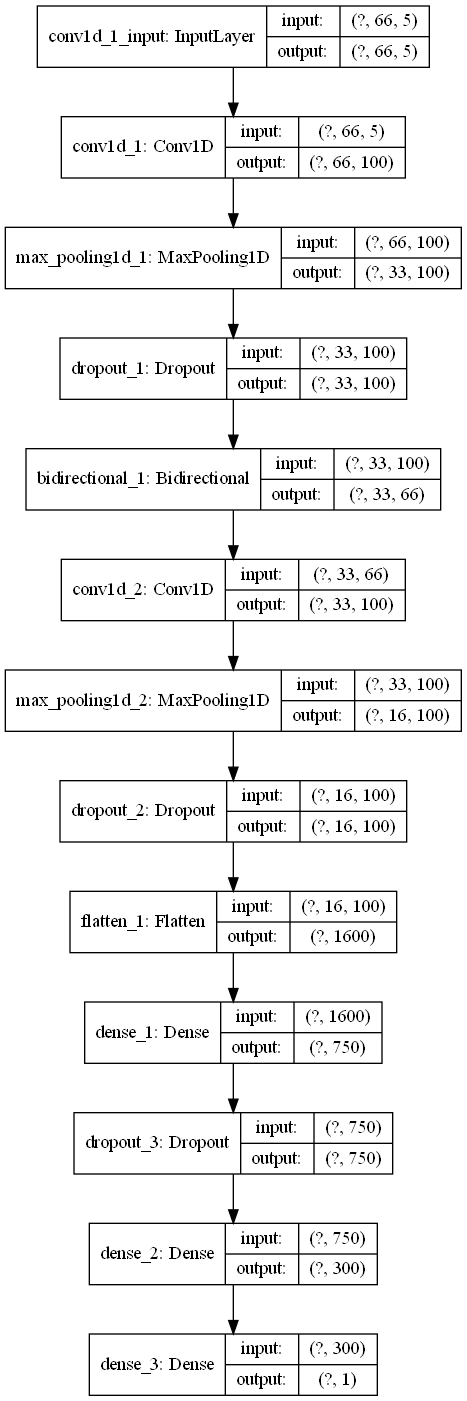

In [10]:
from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, to_file='D:\\liuchaochao\\桌面\\DISMIR\\DISMIR训练模型.png', show_shapes=True)